# Time series classification with fully convolutional neural networks

In [2]:

# Numbers
import numpy as np

# Keras
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

# Plotting
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

First we check a GPU is available by listing the available devices

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5802544244545411878, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11332668621
 locality {
   bus_id: 1
 }
 incarnation: 7224872843010531636
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"]

Load Adiac dataset with numpy

In [3]:
adiac_train = np.loadtxt('UCR_TS_Archive_2015/StarLightCurves/StarLightCurves_TRAIN', delimiter = ',')
adiac_test = np.loadtxt('UCR_TS_Archive_2015/StarLightCurves/StarLightCurves_TEST', delimiter = ',')
x_train = adiac_train[:,1:]
y_train = adiac_train[:,0]
x_test = adiac_test[:,1:]
y_test = adiac_test[:,0]

Preprocess data, convert labels to one hot encodings and normalize the features

In [6]:
y_train.shape

(1000,)

In [4]:
nb_classes = len(np.unique(y_test))

# Fix label range and One-hot encode
# save original labels
y_train_orig = y_train
y_test_orig = y_test

# fix range of labels
y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)

# one-hot encode
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

# Normalize features
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / (x_train_std)
x_test_mean = x_test.mean()
x_test_std = x_test.std()
x_test = (x_test - x_test_mean) / (x_test_std)

# Keras expects input in a (batch_size, seq_size, num_features) format
# in this case the number of features is just one
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

Visualize some of the different categories

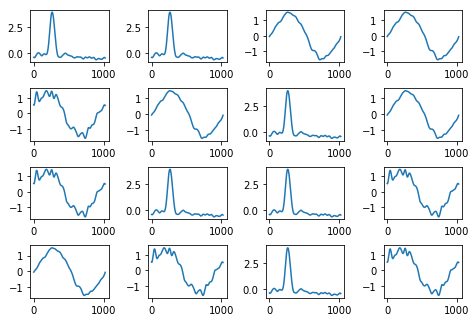

In [8]:
examples = []
for cls in np.unique(y_train_orig):
    one_class = np.where(y_train_orig==cls)
    examples.append(one_class[0][np.random.randint(len(one_class))])

gs = gridspec.GridSpec(4, 4, top=1., bottom=0., right=1., left=0., hspace=0.5,
        wspace=0.5)
i = 0
for g in gs:
    ax = plt.subplot(g)
    ax.plot(adiac_train[examples[np.random.randint(nb_classes)]][1:])
    i += 1

Initialize hyperparameters

In [14]:
epochs = 45
batch_size = min(x_train.shape[0]/10, 16)
learning_rate = 0.00005
batch_normalization_momentum = 0.2

Create keras model, this is a fully convolutional neural network that uses ReLu activations and batch normalization in every layer. In the last layer we use Global Average Pooling.

In [15]:


model = Sequential([
    Conv1D(128, 8, padding='same', input_shape=(x_train.shape[1], 1)),
    BatchNormalization(momentum=batch_normalization_momentum),
    LeakyReLU(),
    # model.add(Activation('relu'))

    Conv1D(256, 5, padding='same'),
    BatchNormalization(momentum=batch_normalization_momentum),
    LeakyReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(momentum=batch_normalization_momentum),
    LeakyReLU(),

    GlobalAveragePooling1D(),
    Dense(nb_classes, activation='softmax')
])

optimizer = Adam(lr=learning_rate)
    
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [16]:
for layer in model.layers:
    print("layer: \"{}\" input_shape:{} , output_shape:{}".format(layer.name, layer.input_shape, layer.output_shape))

layer: "conv1d_4" input_shape:(None, 1024, 1) , output_shape:(None, 1024, 128)
layer: "batch_normalization_4" input_shape:(None, 1024, 128) , output_shape:(None, 1024, 128)
layer: "leaky_re_lu_4" input_shape:(None, 1024, 128) , output_shape:(None, 1024, 128)
layer: "conv1d_5" input_shape:(None, 1024, 128) , output_shape:(None, 1024, 256)
layer: "batch_normalization_5" input_shape:(None, 1024, 256) , output_shape:(None, 1024, 256)
layer: "leaky_re_lu_5" input_shape:(None, 1024, 256) , output_shape:(None, 1024, 256)
layer: "conv1d_6" input_shape:(None, 1024, 256) , output_shape:(None, 1024, 128)
layer: "batch_normalization_6" input_shape:(None, 1024, 128) , output_shape:(None, 1024, 128)
layer: "leaky_re_lu_6" input_shape:(None, 1024, 128) , output_shape:(None, 1024, 128)
layer: "global_average_pooling1d_2" input_shape:(None, 1024, 128) , output_shape:(None, 128)
layer: "dense_2" input_shape:(None, 128) , output_shape:(None, 3)


Train the neural network

In [17]:


early_stopper = EarlyStopping(monitor = 'loss', patience=50) 
hist = model.fit(x_train, y_train, 
                 batch_size, epochs, 1, 
                 validation_data=(x_test, y_test), 
                 callbacks = [early_stopper])

Train on 1000 samples, validate on 8236 samples
Epoch 1/45
1000/1000 [==============================] - 10s - loss: 0.5392 - acc: 0.8130 - val_loss: 0.5130 - val_acc: 0.8312

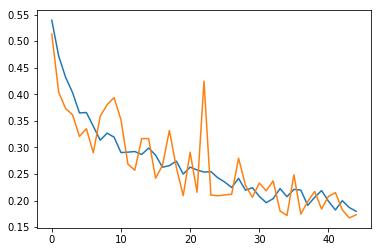

In [22]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(hist.history['loss'])
# plt.plot(moving_average(hist.history['val_loss']))
plt.plot(hist.history['val_loss'])

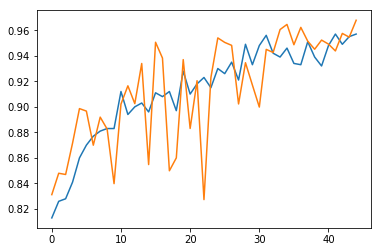

In [23]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])